<b> BIOENGINEERING C142 FINAL PROJECT: SUPERVISED LEARNING ANN MODEL APPLIED TO THE ANI-1 DATASET </b>

<b> DATA PROCESSING </b>

In [48]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [50]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


In [99]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

batch_size = 8192

# Use dataset.collate(...).cache() method to do batching
train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()

In [100]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([
    net_H,
    net_C,
    net_N,
    net_O
])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

train_data_batch = next(iter(train_data_loader))
loss_func = nn.MSELoss()
species = train_data_batch['species'].to(device)
coords = train_data_batch['coordinates'].to(device)
true_energies = train_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies)
print(loss)

tensor(0.0863, grad_fn=<MseLossBackward0>)


<b> TRAINING THE MODEL </b>

In [ ]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
        
        # definition of loss function: MSE is a good choice! 
        loss_func = torch.nn.MSELoss(reduction='none')
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                inputs, true_energies = train_data_batch
                pred_energies = self.model(inputs)
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.mean().backward()
                self.optimizer.step()
                
                batch_importance = 1.0
                train_epoch_loss += batch_loss.mean().item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
        
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validate')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")

        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = torch.utils.data.DataLoader(data, batch_size=self.batch_size)
        
        # init loss function
        loss_func = torch.nn.MSELoss(reduction='none')
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                ts, true_energies = batch_data
                pred_energies = self.model(ts)
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = 1.0
                total_loss += batch_loss.mean().item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

<b> REGULARIZATION STRATEGIES AND HYPERPARAMETER TUNING </b>

In [69]:
import pandas as pd
hyperparameters = [
    {'dropout': 0.1, 'learning_rate': 1e-3, 'l2': 1e-5, 'batch_size': 32, 'hidden_dim': 128},
    {'dropout': 0.2, 'learning_rate': 5e-4, 'l2': 1e-4, 'batch_size': 64, 'hidden_dim': 256},
    {'dropout': 0.3, 'learning_rate': 1e-4, 'l2': 1e-3, 'batch_size': 128, 'hidden_dim': 192},
    {'dropout': 0.15, 'learning_rate': 3e-4, 'l2': 5e-4, 'batch_size': 96, 'hidden_dim': 224},
]

def train_and_evaluate_model(params):
    class TunedAtomicNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Linear(384, params['hidden_dim']),
                nn.BatchNorm1d(params['hidden_dim']),
                nn.ReLU(),
                nn.Dropout(params['dropout']),
                nn.Linear(params['hidden_dim'], params['hidden_dim'] // 2),
                nn.BatchNorm1d(params['hidden_dim'] // 2),
                nn.ReLU(),
                nn.Dropout(params['dropout']),
                nn.Linear(params['hidden_dim'] // 2, 1)
            )
        
        def forward(self, x):
            return self.layers(x)
    
    net_H_tuned = TunedAtomicNet()
    net_C_tuned = TunedAtomicNet()
    net_N_tuned = TunedAtomicNet()
    net_O_tuned = TunedAtomicNet()
    
    ani_net_tuned = torchani.ANIModel([net_H_tuned, net_C_tuned, net_N_tuned, net_O_tuned])
    model_tuned = nn.Sequential(
        aev_computer,
        ani_net_tuned
    ).to(device)
    
    tuned_trainer = ANITrainer(
        model = model_tuned,
        batch_size = params['batch_size'],
        learning_rate = params['learning_rate'],
        epoch = 5,  
        l2 = params['l2']
    )
    
    train_loss, val_loss = tuned_trainer.train(train_data, val_data, draw_curve=False)
    test_loss = tuned_trainer.evaluate(test_data)
    
    return {
        'train_loss': train_loss[-1],
        'val_loss': val_loss[-1],
        'test_loss': test_loss,
        'params': params
    }

results = []
for params in hyperparameters:
    print(f"Testing hyperparameters: {params}")
    result = train_and_evaluate_model(params)
    results.append(result)
    
results_df = pd.DataFrame([
    {
        'dropout': r['params']['dropout'],
        'learning_rate': r['params']['learning_rate'],
        'l2': r['params']['l2'],
        'batch_size': r['params']['batch_size'],
        'hidden_dim': r['params']['hidden_dim'],
        'train_loss': r['train_loss'],
        'val_loss': r['val_loss'],
        'test_loss': r['test_loss']
    } for r in results
])

print("\nHyperparameter tuning results:")
print(results_df)

best_idx = results_df['val_loss'].idxmin()
best_params = results_df.iloc[best_idx]
print(f"\nBest hyperparameters:\n{best_params}")

Testing hyperparameters: {'dropout': 0.1, 'learning_rate': 0.001, 'l2': 1e-05, 'batch_size': 32, 'hidden_dim': 128}
Sequential - Number of parameters: 231940
Initialize training data...


 20%|████████▊                                   | 1/5 [02:59<11:57, 179.30s/it]

Epoch 1/5, Train Loss: 0.221398, Val Loss: 0.000072


 40%|█████████████████▌                          | 2/5 [05:55<08:53, 177.75s/it]

Epoch 2/5, Train Loss: 0.005128, Val Loss: 0.000136


 60%|██████████████████████████▍                 | 3/5 [08:51<05:53, 176.70s/it]

Epoch 3/5, Train Loss: 0.004938, Val Loss: 0.000087


 80%|███████████████████████████████████▏        | 4/5 [11:58<03:00, 180.81s/it]

Epoch 4/5, Train Loss: 0.004879, Val Loss: 0.000166


100%|████████████████████████████████████████████| 5/5 [14:56<00:00, 179.25s/it]

Epoch 5/5, Train Loss: 0.004860, Val Loss: 0.000117


Testing hyperparameters: {'dropout': 0.2, 'learning_rate': 0.0005, 'l2': 0.0001, 'batch_size': 64, 'hidden_dim': 256}
Sequential - Number of parameters: 529412
Initialize training data...


 20%|████████▊                                   | 1/5 [02:29<09:57, 149.36s/it]

Epoch 1/5, Train Loss: 1.361511, Val Loss: 0.000081


 40%|█████████████████▌                          | 2/5 [05:32<08:27, 169.05s/it]

Epoch 2/5, Train Loss: 0.010563, Val Loss: 0.000080


 60%|██████████████████████████▍                 | 3/5 [08:02<05:21, 160.62s/it]

Epoch 3/5, Train Loss: 0.009908, Val Loss: 0.000068


 80%|███████████████████████████████████▏        | 4/5 [12:15<03:17, 197.11s/it]

Epoch 4/5, Train Loss: 0.009778, Val Loss: 0.000136


100%|████████████████████████████████████████████| 5/5 [17:16<00:00, 207.31s/it]

Epoch 5/5, Train Loss: 0.009778, Val Loss: 0.000125


Testing hyperparameters: {'dropout': 0.3, 'learning_rate': 0.0001, 'l2': 0.001, 'batch_size': 128, 'hidden_dim': 192}
Sequential - Number of parameters: 372484
Initialize training data...


 20%|████████▊                                   | 1/5 [01:48<07:13, 108.48s/it]

Epoch 1/5, Train Loss: 24.072285, Val Loss: 0.005331


 40%|█████████████████▌                          | 2/5 [03:30<05:14, 104.97s/it]

Epoch 2/5, Train Loss: 0.128526, Val Loss: 0.000722


 60%|██████████████████████████▍                 | 3/5 [08:13<06:12, 186.12s/it]

Epoch 3/5, Train Loss: 0.021067, Val Loss: 0.000101


 80%|███████████████████████████████████▏        | 4/5 [25:46<08:48, 528.12s/it]

Epoch 4/5, Train Loss: 0.018767, Val Loss: 0.000226


100%|████████████████████████████████████████████| 5/5 [42:32<00:00, 510.49s/it]

Epoch 5/5, Train Loss: 0.019608, Val Loss: 0.000204


Testing hyperparameters: {'dropout': 0.15, 'learning_rate': 0.0003, 'l2': 0.0005, 'batch_size': 96, 'hidden_dim': 224}
Sequential - Number of parameters: 448900
Initialize training data...


 20%|████████▊                                   | 1/5 [02:05<08:22, 125.72s/it]

Epoch 1/5, Train Loss: 5.640225, Val Loss: 0.000506


 40%|█████████████████▏                         | 2/5 [34:14<59:18, 1186.26s/it]

Epoch 2/5, Train Loss: 0.017516, Val Loss: 0.000091


 60%|████████████████████████▌                | 3/5 [1:06:18<50:46, 1523.01s/it]

Epoch 3/5, Train Loss: 0.014624, Val Loss: 0.000068


 80%|████████████████████████████████▊        | 4/5 [1:42:25<29:37, 1777.57s/it]

Epoch 4/5, Train Loss: 0.014621, Val Loss: 0.000122


100%|█████████████████████████████████████████| 5/5 [2:16:48<00:00, 1641.61s/it]

Epoch 5/5, Train Loss: 0.014781, Val Loss: 0.000176



Hyperparameter tuning results:
   dropout  learning_rate       l2  batch_size  hidden_dim  train_loss  \
0     0.10         0.0010  0.00001          32         128    0.004860   
1     0.20         0.0005  0.00010          64         256    0.009778   
2     0.30         0.0001  0.00100         128         192    0.019608   
3     0.15         0.0003  0.00050          96         224    0.014781   

   val_loss                                    test_loss  
0  0.000117  (0.00011622550809342666, 4.344661766435291)  
1  0.000125  (0.00012524655379812875, 4.708810843713847)  
2  0.000204  (0.00020093037068378707, 6.783026111458998)  
3  0.000176   (0.0001768818727721286, 6.689246992031974)  

Best hyperparameters:
dropout                                                  0.1
learning_rate                                          0.001
l2                                                   0.00001
batch_size                                                32
hidden_dim                         

Model parameters: 248,580
Training for up to 50 epochs


  2%|▉                                           | 1/50 [00:05<04:29,  5.49s/it]

  Epoch 1: Train Loss=0.016267, Val Loss=0.003127


 10%|████▍                                       | 5/50 [00:26<03:59,  5.31s/it]

  Epoch 5: Train Loss=0.000687, Val Loss=0.000383


 20%|████████▌                                  | 10/50 [00:52<03:25,  5.15s/it]

  Epoch 10: Train Loss=0.000219, Val Loss=0.000115


 30%|████████████▉                              | 15/50 [01:18<03:06,  5.32s/it]

  Epoch 15: Train Loss=0.000170, Val Loss=0.000092


 38%|████████████████▎                          | 19/50 [01:45<02:51,  5.54s/it]

  Epoch 20: Train Loss=0.000149, Val Loss=0.000098
  Early stopping at epoch 20


Final test loss: (3.867146358859462, 6.703376947409133, array([-0.01599002, -0.01455238, -0.092524  , ..., -0.01382233,
       -0.00508499,  0.0068129 ], dtype=float32), array([-0.01817197, -0.00957318, -0.11217892, ..., -0.01150317,
       -0.00370553,  0.00862585], dtype=float32))


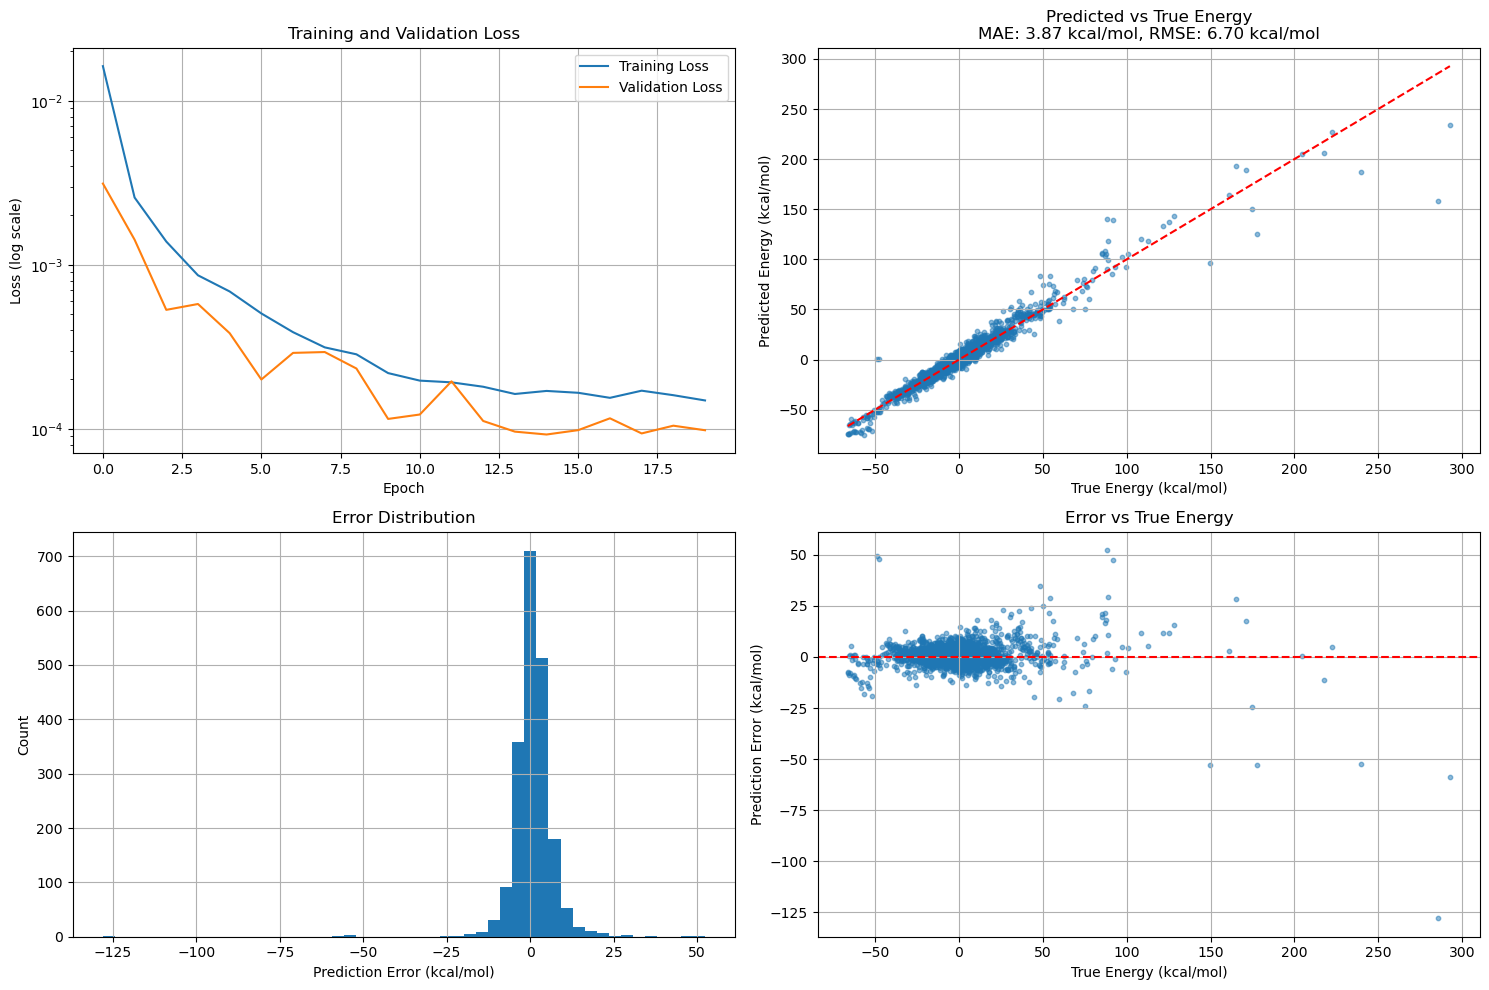


===== Final Model Summary =====
Architecture: 384 -> 128 -> 64 -> 64 -> 1
Dropout rate: 0.1
L2 regularization: 1e-05
Learning rate: 0.001
Batch size: 32
MAE: 3.8671 kcal/mol
RMSE: 6.7034 kcal/mol


In [216]:
best_dropout = 0.1
best_learning_rate = 0.001
best_l2 = 0.00001 
best_batch_size = 32
best_hidden_dim = 128

class FinalAtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, best_hidden_dim),
            nn.BatchNorm1d(best_hidden_dim),
            nn.ReLU(),
            nn.Dropout(best_dropout),
            nn.Linear(best_hidden_dim, best_hidden_dim // 2),
            nn.BatchNorm1d(best_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(best_dropout),
            nn.Linear(best_hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H_final = FinalAtomicNet()
net_C_final = FinalAtomicNet()
net_N_final = FinalAtomicNet()
net_O_final = FinalAtomicNet()

ani_net_final = torchani.ANIModel([net_H_final, net_C_final, net_N_final, net_O_final])
final_model = nn.Sequential(
    aev_computer,
    ani_net_final
).to(device)

traindata_full = list(islice(train_data, 20000))  
validation_full = list(islice(val_data, 2000))   
test_full = list(islice(test_data, 2000))       

train_data_full = torchani.data.TransformableIterable(traindata_full)
val_data_full = torchani.data.TransformableIterable(validation_full)
test_data_full = torchani.data.TransformableIterable(test_full)

final_trainer = ANITrainer(
    model = final_model,
    batch_size = best_batch_size,
    learning_rate = best_learning_rate,
    epoch = 50,  
    l2 = best_l2
)

train_loss_final, val_loss_final = final_trainer.train(train_data_full, val_data_full)
test_data_loader = test_data_full.collate(best_batch_size).cache()
test_loss_final = final_trainer.evaluate(test_data_loader)
print(f"Final test loss: {test_loss_final}")
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.semilogy(train_loss_final, label='Training Loss')
plt.semilogy(val_loss_final, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
true_values = []
pred_values = []

test_loader = test_data_full.collate(best_batch_size).cache()
with torch.no_grad():
    for batch_data in test_loader:
        species = batch_data['species'].to(device)
        coordinates = batch_data['coordinates'].to(device)
        true_energies = batch_data['energies'].to(device).float()
        _, pred_energies = final_model((species, coordinates))
        
        true_values.append(true_energies.cpu().numpy())
        pred_values.append(pred_energies.cpu().numpy())

true_values = np.concatenate(true_values)
pred_values = np.concatenate(pred_values)
hartree2kcalmol = 627.5094738898777
true_values_kcal = true_values * hartree2kcalmol
pred_values_kcal = pred_values * hartree2kcalmol

mae = np.mean(np.abs(true_values_kcal - pred_values_kcal))
rmse = np.sqrt(np.mean((true_values_kcal - pred_values_kcal)**2))
plt.scatter(true_values_kcal, pred_values_kcal, alpha=0.5, s=10)
plt.plot([min(true_values_kcal), max(true_values_kcal)], 
         [min(true_values_kcal), max(true_values_kcal)], 'r--')
plt.xlabel('True Energy (kcal/mol)')
plt.ylabel('Predicted Energy (kcal/mol)')
plt.title(f'Predicted vs True Energy\nMAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol')
plt.grid(True)

plt.subplot(2, 2, 3)
errors = pred_values_kcal - true_values_kcal
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error (kcal/mol)')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(true_values_kcal, errors, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Energy (kcal/mol)')
plt.ylabel('Prediction Error (kcal/mol)')
plt.title('Error vs True Energy')
plt.grid(True)

plt.tight_layout()
plt.savefig('ani_model_performance.png', dpi=300)
plt.show()

print("\n===== Final Model Summary =====")
print(f"Architecture: 384 -> {best_hidden_dim} -> {best_hidden_dim//2} -> 64 -> 1")
print(f"Dropout rate: {best_dropout}")
print(f"L2 regularization: {best_l2}")
print(f"Learning rate: {best_learning_rate}")
print(f"Batch size: {best_batch_size}")
print(f"MAE: {mae:.4f} kcal/mol")
print(f"RMSE: {rmse:.4f} kcal/mol")
print("=============================")

<b> FINAL PRODUCTION MODE: MULTIPLE RUNS AND N-FOLD CROSS-VALIDATION </b>

Preparing dataset for cross-validation...

=== Run 1/3 ===
Fold 1/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:10,  2.43s/it]

  Epoch 1: Train Loss=0.087933, Val Loss=0.008515


 17%|███████▎                                    | 5/30 [00:12<01:03,  2.52s/it]

  Epoch 5: Train Loss=0.009538, Val Loss=0.002931


 27%|███████████▋                                | 8/30 [00:22<01:02,  2.86s/it]

  Early stopping at epoch 9


  Fold 1 - MAE: 40.0780 kcal/mol, RMSE: 44.6460 kcal/mol
Fold 2/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:09,  2.41s/it]

  Epoch 1: Train Loss=0.145906, Val Loss=0.022056


 17%|███████▎                                    | 5/30 [00:12<01:02,  2.51s/it]

  Epoch 5: Train Loss=0.011326, Val Loss=0.004208


 30%|█████████████▏                              | 9/30 [00:26<01:01,  2.93s/it]

  Epoch 10: Train Loss=0.004730, Val Loss=0.006085
  Early stopping at epoch 10


  Fold 2 - MAE: 41.1432 kcal/mol, RMSE: 48.9485 kcal/mol
Fold 3/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:18,  2.70s/it]

  Epoch 1: Train Loss=0.046539, Val Loss=0.008914


 17%|███████▎                                    | 5/30 [00:13<01:06,  2.64s/it]

  Epoch 5: Train Loss=0.005101, Val Loss=0.001773


 33%|██████████████▎                            | 10/30 [00:26<00:53,  2.68s/it]

  Epoch 10: Train Loss=0.001742, Val Loss=0.000428


 50%|█████████████████████▌                     | 15/30 [00:39<00:39,  2.66s/it]

  Epoch 15: Train Loss=0.000866, Val Loss=0.000259


 67%|████████████████████████████▋              | 20/30 [00:52<00:26,  2.62s/it]

  Epoch 20: Train Loss=0.000469, Val Loss=0.000132


 83%|███████████████████████████████████▊       | 25/30 [01:05<00:12,  2.58s/it]

  Epoch 25: Train Loss=0.000325, Val Loss=0.000111


100%|███████████████████████████████████████████| 30/30 [01:18<00:00,  2.62s/it]

  Epoch 30: Train Loss=0.000237, Val Loss=0.000090


  Fold 3 - MAE: 4.1324 kcal/mol, RMSE: 5.9524 kcal/mol
Fold 4/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:10,  2.43s/it]

  Epoch 1: Train Loss=0.121764, Val Loss=0.028509


 17%|███████▎                                    | 5/30 [00:13<01:10,  2.84s/it]

  Epoch 5: Train Loss=0.011668, Val Loss=0.002760


 33%|██████████████▎                            | 10/30 [00:27<00:54,  2.70s/it]

  Epoch 10: Train Loss=0.004542, Val Loss=0.001081


 47%|████████████████████                       | 14/30 [00:40<00:46,  2.92s/it]

  Epoch 15: Train Loss=0.002382, Val Loss=0.001492
  Early stopping at epoch 15


  Fold 4 - MAE: 20.5105 kcal/mol, RMSE: 24.2364 kcal/mol
Fold 5/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:13,  2.53s/it]

  Epoch 1: Train Loss=0.067032, Val Loss=0.019956


 17%|███████▎                                    | 5/30 [00:13<01:07,  2.69s/it]

  Epoch 5: Train Loss=0.006727, Val Loss=0.001770


 33%|██████████████▎                            | 10/30 [00:26<00:53,  2.70s/it]

  Epoch 10: Train Loss=0.002357, Val Loss=0.001300


 50%|█████████████████████▌                     | 15/30 [00:40<00:40,  2.73s/it]

  Epoch 15: Train Loss=0.001063, Val Loss=0.000532


 67%|████████████████████████████▋              | 20/30 [00:53<00:26,  2.62s/it]

  Epoch 20: Train Loss=0.000502, Val Loss=0.000314


 83%|███████████████████████████████████▊       | 25/30 [01:07<00:13,  2.63s/it]

  Epoch 25: Train Loss=0.000317, Val Loss=0.000171


100%|███████████████████████████████████████████| 30/30 [01:19<00:00,  2.66s/it]

  Epoch 30: Train Loss=0.000219, Val Loss=0.000126


  Fold 5 - MAE: 4.4549 kcal/mol, RMSE: 7.0305 kcal/mol
Run 1 Results - Mean MAE: 22.0638 ± 16.2638 kcal/mol
Run 1 Results - Mean RMSE: 26.1628 ± 18.1054 kcal/mol

=== Run 2/3 ===
Fold 1/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:12,  2.50s/it]

  Epoch 1: Train Loss=0.055125, Val Loss=0.007660


 17%|███████▎                                    | 5/30 [00:14<01:18,  3.13s/it]

  Epoch 5: Train Loss=0.006214, Val Loss=0.011338


 23%|██████████▎                                 | 7/30 [00:25<01:23,  3.61s/it]

  Early stopping at epoch 8


  Fold 1 - MAE: 59.2199 kcal/mol, RMSE: 65.9586 kcal/mol
Fold 2/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:25,  2.96s/it]

  Epoch 1: Train Loss=0.071948, Val Loss=0.019088


 17%|███████▎                                    | 5/30 [00:15<01:13,  2.92s/it]

  Epoch 5: Train Loss=0.008019, Val Loss=0.002281


 33%|██████████████▎                            | 10/30 [00:28<00:54,  2.73s/it]

  Epoch 10: Train Loss=0.002885, Val Loss=0.001016


 50%|█████████████████████▌                     | 15/30 [00:42<00:40,  2.69s/it]

  Epoch 15: Train Loss=0.001502, Val Loss=0.000650


 67%|████████████████████████████▋              | 20/30 [00:55<00:25,  2.53s/it]

  Epoch 20: Train Loss=0.000942, Val Loss=0.000481


 83%|███████████████████████████████████▊       | 25/30 [01:08<00:12,  2.57s/it]

  Epoch 25: Train Loss=0.000579, Val Loss=0.000250


100%|███████████████████████████████████████████| 30/30 [01:20<00:00,  2.70s/it]

  Epoch 30: Train Loss=0.000444, Val Loss=0.000192


  Fold 2 - MAE: 6.2237 kcal/mol, RMSE: 8.6938 kcal/mol
Fold 3/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:10,  2.45s/it]

  Epoch 1: Train Loss=0.146642, Val Loss=0.030907


 17%|███████▎                                    | 5/30 [00:12<01:03,  2.54s/it]

  Epoch 5: Train Loss=0.011842, Val Loss=0.005975


 33%|██████████████▎                            | 10/30 [00:25<00:50,  2.53s/it]

  Epoch 10: Train Loss=0.004549, Val Loss=0.001850


 50%|█████████████████████▌                     | 15/30 [00:37<00:37,  2.52s/it]

  Epoch 15: Train Loss=0.002395, Val Loss=0.001005


 67%|████████████████████████████▋              | 20/30 [00:50<00:25,  2.56s/it]

  Epoch 20: Train Loss=0.001407, Val Loss=0.000743


 83%|███████████████████████████████████▊       | 25/30 [01:02<00:12,  2.47s/it]

  Epoch 25: Train Loss=0.000832, Val Loss=0.000627


100%|███████████████████████████████████████████| 30/30 [01:15<00:00,  2.53s/it]

  Epoch 30: Train Loss=0.000553, Val Loss=0.000398


  Fold 3 - MAE: 9.3334 kcal/mol, RMSE: 12.5188 kcal/mol
Fold 4/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:11,  2.47s/it]

  Epoch 1: Train Loss=0.119853, Val Loss=0.008550


 17%|███████▎                                    | 5/30 [00:12<01:01,  2.47s/it]

  Epoch 5: Train Loss=0.010532, Val Loss=0.002678


 33%|██████████████▎                            | 10/30 [00:25<00:50,  2.52s/it]

  Epoch 10: Train Loss=0.004258, Val Loss=0.001197


 50%|█████████████████████▌                     | 15/30 [00:37<00:37,  2.49s/it]

  Epoch 15: Train Loss=0.002243, Val Loss=0.000551


 67%|████████████████████████████▋              | 20/30 [00:50<00:25,  2.50s/it]

  Epoch 20: Train Loss=0.001315, Val Loss=0.000347


 83%|███████████████████████████████████▊       | 25/30 [01:02<00:12,  2.51s/it]

  Epoch 25: Train Loss=0.000864, Val Loss=0.000300


100%|███████████████████████████████████████████| 30/30 [01:14<00:00,  2.50s/it]

  Epoch 30: Train Loss=0.000526, Val Loss=0.000216


  Fold 4 - MAE: 6.8178 kcal/mol, RMSE: 9.2223 kcal/mol
Fold 5/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:10,  2.42s/it]

  Epoch 1: Train Loss=0.081942, Val Loss=0.009958


 17%|███████▎                                    | 5/30 [00:14<01:16,  3.04s/it]

  Epoch 5: Train Loss=0.007855, Val Loss=0.003369


 33%|██████████████▎                            | 10/30 [00:26<00:50,  2.53s/it]

  Epoch 10: Train Loss=0.003151, Val Loss=0.001282


 50%|█████████████████████▌                     | 15/30 [00:38<00:37,  2.51s/it]

  Epoch 15: Train Loss=0.001611, Val Loss=0.001048


 67%|████████████████████████████▋              | 20/30 [00:51<00:24,  2.46s/it]

  Epoch 20: Train Loss=0.000906, Val Loss=0.000848


 83%|███████████████████████████████████▊       | 25/30 [01:04<00:12,  2.56s/it]

  Epoch 25: Train Loss=0.000600, Val Loss=0.000256


100%|███████████████████████████████████████████| 30/30 [01:16<00:00,  2.56s/it]

  Epoch 30: Train Loss=0.000412, Val Loss=0.000356


  Fold 5 - MAE: 9.8927 kcal/mol, RMSE: 11.8340 kcal/mol
Run 2 Results - Mean MAE: 18.2975 ± 20.5095 kcal/mol
Run 2 Results - Mean RMSE: 21.6455 ± 22.2049 kcal/mol

=== Run 3/3 ===
Fold 1/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:09,  2.40s/it]

  Epoch 1: Train Loss=0.100571, Val Loss=0.031118


 17%|███████▎                                    | 5/30 [00:13<01:07,  2.72s/it]

  Epoch 5: Train Loss=0.010568, Val Loss=0.011359


 27%|███████████▋                                | 8/30 [00:23<01:05,  2.99s/it]

  Early stopping at epoch 9


  Fold 1 - MAE: 38.3499 kcal/mol, RMSE: 48.4545 kcal/mol
Fold 2/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:25,  2.94s/it]

  Epoch 1: Train Loss=0.053728, Val Loss=0.019663


 17%|███████▎                                    | 5/30 [00:13<01:03,  2.52s/it]

  Epoch 5: Train Loss=0.004828, Val Loss=0.002942


 33%|██████████████▎                            | 10/30 [00:25<00:49,  2.47s/it]

  Epoch 10: Train Loss=0.001802, Val Loss=0.001053


 50%|█████████████████████▌                     | 15/30 [00:37<00:37,  2.47s/it]

  Epoch 15: Train Loss=0.000825, Val Loss=0.000439


 67%|████████████████████████████▋              | 20/30 [00:50<00:24,  2.47s/it]

  Epoch 20: Train Loss=0.000460, Val Loss=0.000251


 83%|███████████████████████████████████▊       | 25/30 [01:02<00:12,  2.53s/it]

  Epoch 25: Train Loss=0.000269, Val Loss=0.000149


100%|███████████████████████████████████████████| 30/30 [01:15<00:00,  2.51s/it]

  Epoch 30: Train Loss=0.000204, Val Loss=0.000101


  Fold 2 - MAE: 4.4258 kcal/mol, RMSE: 6.2959 kcal/mol
Fold 3/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:05,  2.25s/it]

  Epoch 1: Train Loss=0.101140, Val Loss=0.033214


 17%|███████▎                                    | 5/30 [00:12<01:05,  2.62s/it]

  Epoch 5: Train Loss=0.009380, Val Loss=0.008616


 33%|██████████████▎                            | 10/30 [00:25<00:50,  2.53s/it]

  Epoch 10: Train Loss=0.003644, Val Loss=0.006468


 50%|█████████████████████▌                     | 15/30 [00:38<00:37,  2.53s/it]

  Epoch 15: Train Loss=0.001859, Val Loss=0.003552


 67%|████████████████████████████▋              | 20/30 [00:50<00:24,  2.49s/it]

  Epoch 20: Train Loss=0.001077, Val Loss=0.001305


 83%|███████████████████████████████████▊       | 25/30 [01:02<00:12,  2.50s/it]

  Epoch 25: Train Loss=0.000638, Val Loss=0.000599


100%|███████████████████████████████████████████| 30/30 [01:15<00:00,  2.53s/it]

  Epoch 30: Train Loss=0.000391, Val Loss=0.000284


  Fold 3 - MAE: 7.7333 kcal/mol, RMSE: 10.5720 kcal/mol
Fold 4/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:06,  2.28s/it]

  Epoch 1: Train Loss=0.085252, Val Loss=0.013358


 17%|███████▎                                    | 5/30 [00:12<01:01,  2.44s/it]

  Epoch 5: Train Loss=0.008696, Val Loss=0.003984


 33%|██████████████▎                            | 10/30 [00:25<00:53,  2.66s/it]

  Epoch 10: Train Loss=0.003471, Val Loss=0.000878


 50%|█████████████████████▌                     | 15/30 [00:41<00:45,  3.05s/it]

  Epoch 15: Train Loss=0.001783, Val Loss=0.001134


 67%|████████████████████████████▋              | 20/30 [00:54<00:27,  2.72s/it]

  Epoch 20: Train Loss=0.000962, Val Loss=0.000316


 83%|███████████████████████████████████▊       | 25/30 [01:07<00:13,  2.69s/it]

  Epoch 25: Train Loss=0.000596, Val Loss=0.000165


100%|███████████████████████████████████████████| 30/30 [01:21<00:00,  2.71s/it]

  Epoch 30: Train Loss=0.000365, Val Loss=0.000127


  Fold 4 - MAE: 4.8776 kcal/mol, RMSE: 7.0608 kcal/mol
Fold 5/5
Model parameters: 477,636
Training for up to 30 epochs


  3%|█▍                                          | 1/30 [00:02<01:14,  2.57s/it]

  Epoch 1: Train Loss=0.070283, Val Loss=0.010433


 17%|███████▎                                    | 5/30 [00:12<01:03,  2.55s/it]

  Epoch 5: Train Loss=0.006545, Val Loss=0.002377


 33%|██████████████▎                            | 10/30 [00:25<00:53,  2.65s/it]

  Epoch 10: Train Loss=0.002532, Val Loss=0.001611


 50%|█████████████████████▌                     | 15/30 [00:39<00:39,  2.66s/it]

  Epoch 15: Train Loss=0.001279, Val Loss=0.000836


 67%|████████████████████████████▋              | 20/30 [00:52<00:26,  2.60s/it]

  Epoch 20: Train Loss=0.000721, Val Loss=0.000465


 83%|███████████████████████████████████▊       | 25/30 [01:05<00:12,  2.58s/it]

  Epoch 25: Train Loss=0.000463, Val Loss=0.000267


100%|███████████████████████████████████████████| 30/30 [01:17<00:00,  2.60s/it]

  Epoch 30: Train Loss=0.000339, Val Loss=0.000122


  Fold 5 - MAE: 4.8847 kcal/mol, RMSE: 6.9185 kcal/mol
Run 3 Results - Mean MAE: 12.0543 ± 13.2002 kcal/mol
Run 3 Results - Mean RMSE: 15.8604 ± 16.3659 kcal/mol

=== Training Final Production Model ===
Model parameters: 477,636
Training final model on all training data...
Training for up to 60 epochs


  2%|▋                                           | 1/60 [00:03<03:22,  3.44s/it]

  Epoch 1: Train Loss=0.198912, Val Loss=0.028161


  8%|███▋                                        | 5/60 [00:18<03:25,  3.74s/it]

  Epoch 5: Train Loss=0.010593, Val Loss=0.007089


 17%|███████▏                                   | 10/60 [00:36<03:01,  3.63s/it]

  Epoch 10: Train Loss=0.003820, Val Loss=0.001259


 25%|██████████▊                                | 15/60 [00:54<02:43,  3.63s/it]

  Epoch 15: Train Loss=0.001749, Val Loss=0.000903


 33%|██████████████▎                            | 20/60 [01:13<02:29,  3.73s/it]

  Epoch 20: Train Loss=0.000927, Val Loss=0.000358


 42%|█████████████████▉                         | 25/60 [01:31<02:08,  3.68s/it]

  Epoch 25: Train Loss=0.000476, Val Loss=0.000299


 43%|██████████████████▋                        | 26/60 [01:38<02:09,  3.80s/it]

  Early stopping at epoch 27
Evaluating final model on test set...


Final model saved to 'ani_final_model.pt'


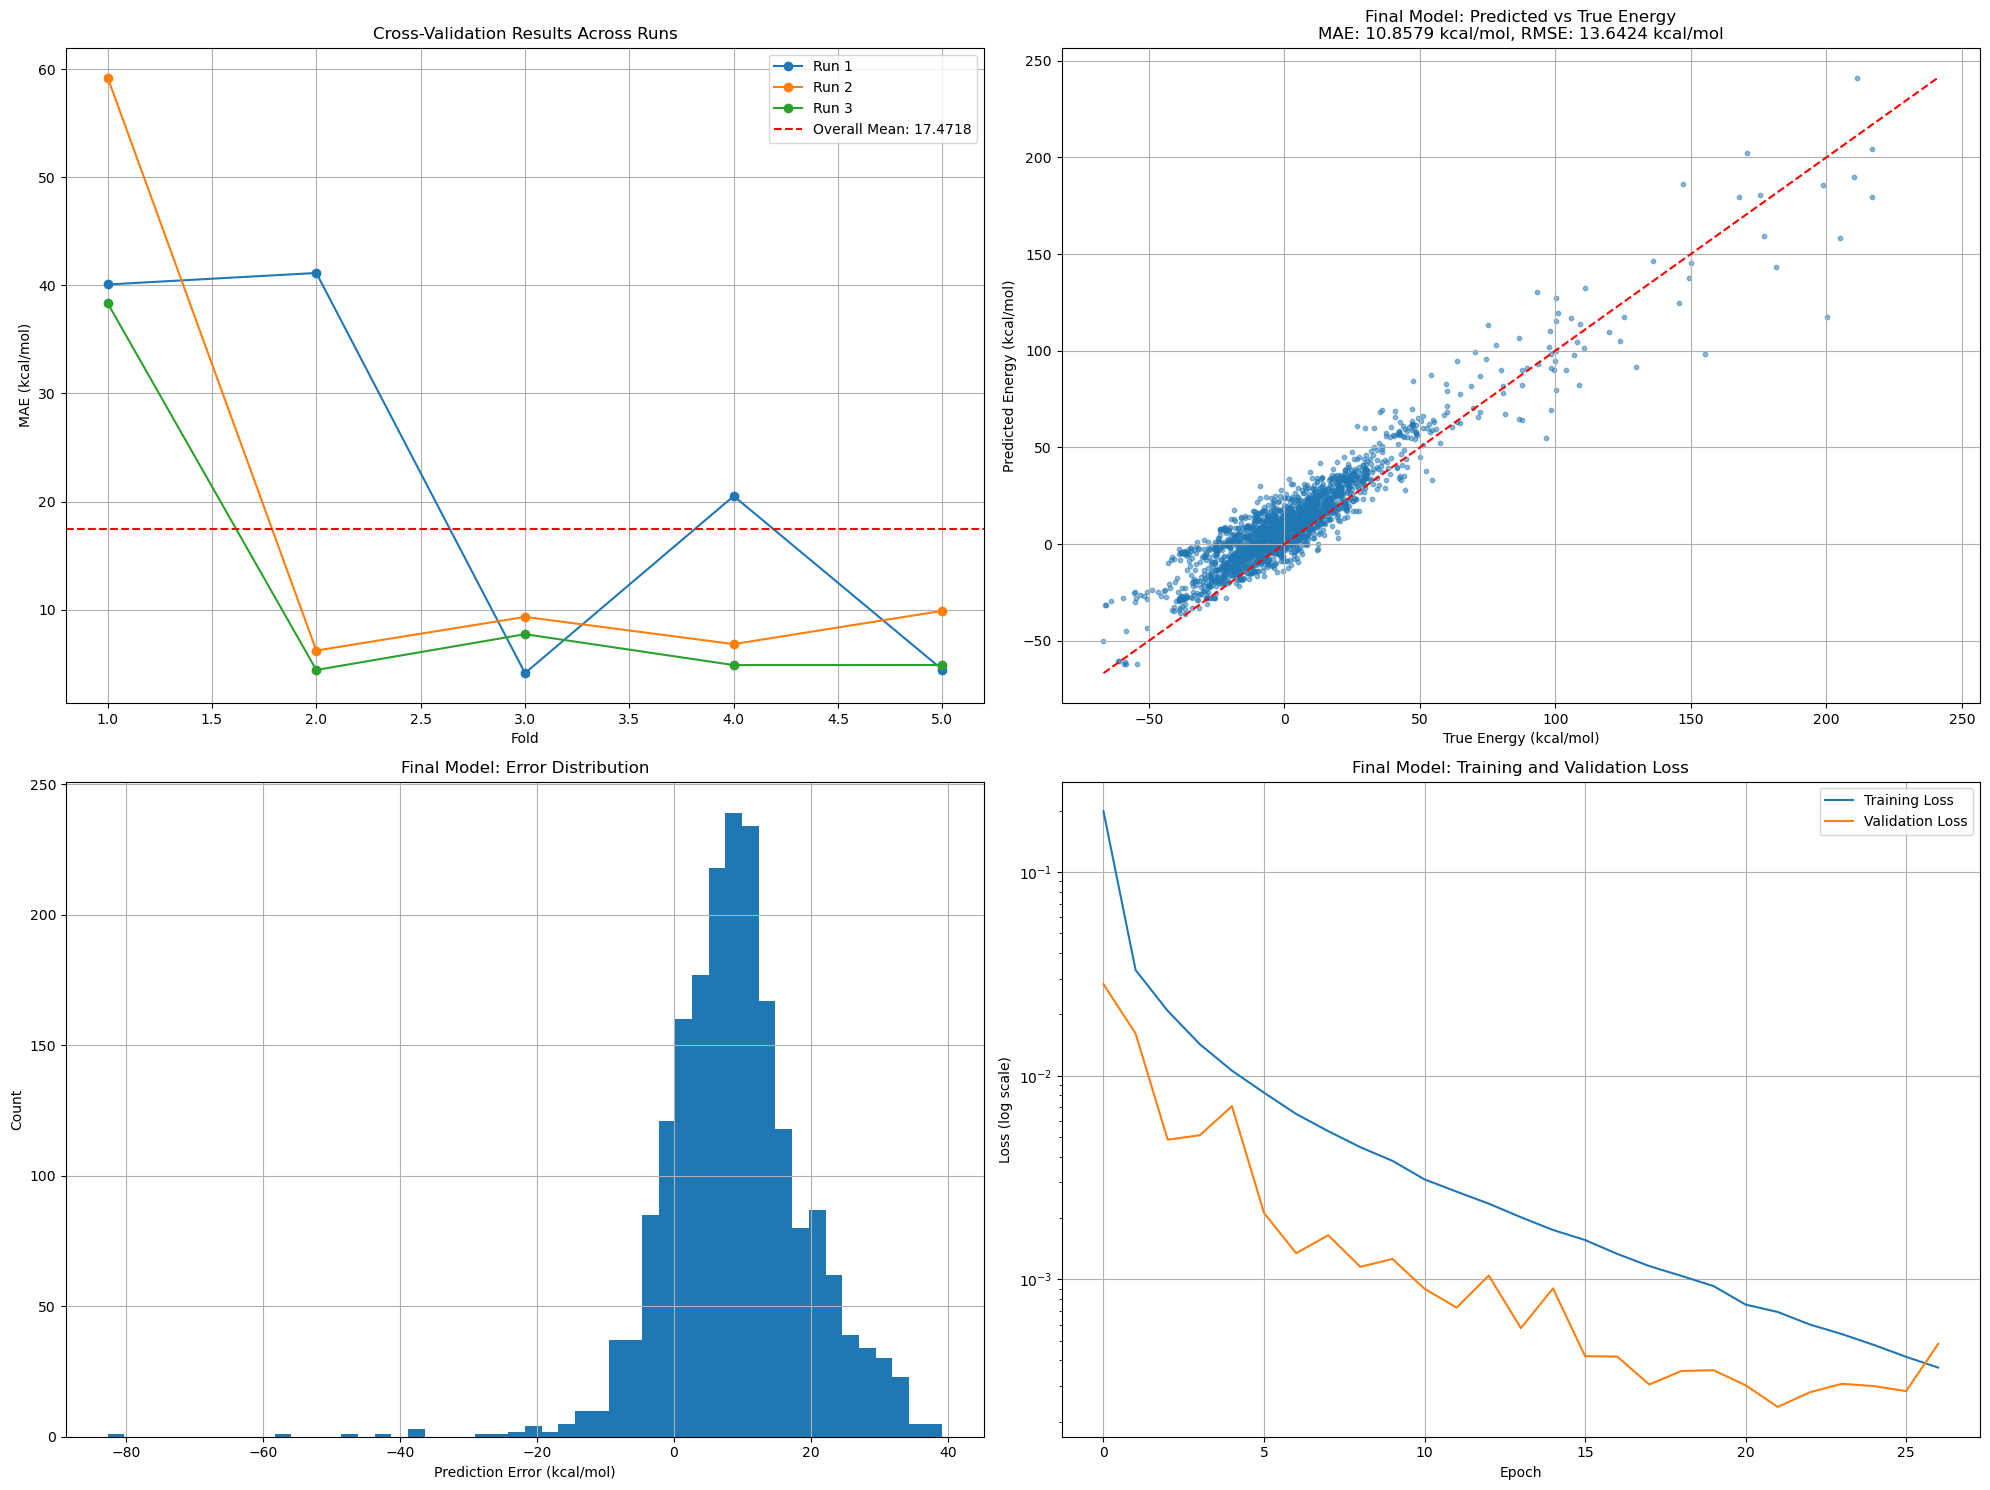


===== Cross-Validation Results Summary =====
Run 1: MAE = 22.0638 ± 16.2638 kcal/mol, RMSE = 26.1628 ± 18.1054 kcal/mol
Run 2: MAE = 18.2975 ± 20.5095 kcal/mol, RMSE = 21.6455 ± 22.2049 kcal/mol
Run 3: MAE = 12.0543 ± 13.2002 kcal/mol, RMSE = 15.8604 ± 16.3659 kcal/mol

===== Overall Cross-Validation Results =====
Mean MAE: 17.4719 ± 16.6578 kcal/mol
Mean RMSE: 21.2229 ± 18.8921 kcal/mol

===== Final Production Model Results =====
MAE: 10.8579 kcal/mol
RMSE: 13.6424 kcal/mol


In [201]:
import numpy as np
import torch
import time
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from itertools import islice

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

N_FOLDS = 5
N_RUNS = 3
EPOCHS = 30  
hartree2kcalmol = 627.5094738898777

def create_model():
    class FinalAtomicNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Linear(384, best_hidden_dim),
                nn.BatchNorm1d(best_hidden_dim),
                nn.ReLU(),
                nn.Dropout(best_dropout),
                nn.Linear(best_hidden_dim, best_hidden_dim // 2),
                nn.BatchNorm1d(best_hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(best_dropout),
                nn.Linear(best_hidden_dim // 2, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.layers(x)
    
    net_H = FinalAtomicNet()
    net_C = FinalAtomicNet()
    net_N = FinalAtomicNet()
    net_O = FinalAtomicNet()
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model = nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)
    
    return model

def evaluate_model(model, test_data):
    test_loader = test_data.collate(best_batch_size).cache()
    true_values = []
    pred_values = []
    
    with torch.no_grad():
        for batch_data in test_loader:
            species = batch_data['species'].to(device)
            coordinates = batch_data['coordinates'].to(device)
            true_energies = batch_data['energies'].to(device).float()
            _, pred_energies = model((species, coordinates))
            
            true_values.append(true_energies.cpu().numpy())
            pred_values.append(pred_energies.cpu().numpy())
    
    true_values = np.concatenate(true_values)
    pred_values = np.concatenate(pred_values)
    
    true_values_kcal = true_values * hartree2kcalmol
    pred_values_kcal = pred_values * hartree2kcalmol
    
    mae = np.mean(np.abs(true_values_kcal - pred_values_kcal))
    rmse = np.sqrt(np.mean((true_values_kcal - pred_values_kcal)**2))
    
    return {
        'mae': mae,
        'rmse': rmse,
        'true_values': true_values_kcal,
        'pred_values': pred_values_kcal
    }

print("Preparing dataset for cross-validation...")
full_data = list(islice(train_data, 15000)) + list(islice(val_data, 1500))
full_dataset = torchani.data.TransformableIterable(full_data)

cv_results = []
run_results = []
s
for run in range(N_RUNS):
    print(f"\n=== Run {run+1}/{N_RUNS} ===")
    run_mae = []
    run_rmse = []
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=run)
    fold_indices = list(kf.split(full_data))
    
    for fold, (train_idx, val_idx) in enumerate(fold_indices):
        print(f"Fold {fold+1}/{N_FOLDS}")
        
        fold_train_data = [full_data[i] for i in train_idx]
        fold_val_data = [full_data[i] for i in val_idx]
        
        fold_train_dataset = torchani.data.TransformableIterable(fold_train_data)
        fold_val_dataset = torchani.data.TransformableIterable(fold_val_data)
        
        model = create_model()
        trainer = ANITrainer(
            model=model,
            batch_size=best_batch_size,
            learning_rate=best_learning_rate,
            epoch=EPOCHS,
            l2=best_l2
        )
        
        with torch.autograd.set_detect_anomaly(False):
            train_loss, val_loss = trainer.train(fold_train_dataset, fold_val_dataset, 
                                               draw_curve=False)
        
        metrics = evaluate_model(model, fold_val_dataset)
        run_mae.append(metrics['mae'])
        run_rmse.append(metrics['rmse'])
        
        cv_results.append({
            'run': run + 1,
            'fold': fold + 1,
            'mae': metrics['mae'],
            'rmse': metrics['rmse'],
            'train_loss': train_loss[-1],
            'val_loss': val_loss[-1]
        })
        
        print(f"  Fold {fold+1} - MAE: {metrics['mae']:.4f} kcal/mol, RMSE: {metrics['rmse']:.4f} kcal/mol")
    
    run_results.append({
        'run': run + 1,
        'mean_mae': np.mean(run_mae),
        'std_mae': np.std(run_mae),
        'mean_rmse': np.mean(run_rmse),
        'std_rmse': np.std(run_rmse)
    })
    
    print(f"Run {run+1} Results - Mean MAE: {np.mean(run_mae):.4f} ± {np.std(run_mae):.4f} kcal/mol")
    print(f"Run {run+1} Results - Mean RMSE: {np.mean(run_rmse):.4f} ± {np.std(run_rmse):.4f} kcal/mol")

print("\n=== Training Final Production Model ===")
final_model = create_model()
final_trainer = ANITrainer(
    model=final_model,
    batch_size=best_batch_size,
    learning_rate=best_learning_rate,
    epoch=EPOCHS * 2,  
    l2=best_l2
)

print("Training final model on all training data...")
final_train_loss, final_val_loss = final_trainer.train(train_data_full, val_data_full, draw_curve=False)

print("Evaluating final model on test set...")
final_metrics = evaluate_model(final_model, test_data_full)

torch.save(final_model.state_dict(), 'ani_final_model.pt')
print("Final model saved to 'ani_final_model.pt'")

plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
run_nums = [result['run'] for result in cv_results]
fold_nums = [result['fold'] for result in cv_results]
maes = [result['mae'] for result in cv_results]
rmses = [result['rmse'] for result in cv_results]

for run in range(1, N_RUNS + 1):
    run_maes = [mae for r, mae, in zip(run_nums, maes) if r == run]
    run_folds = [f for r, f in zip(run_nums, fold_nums) if r == run]
    plt.plot(run_folds, run_maes, marker='o', label=f'Run {run}')

plt.axhline(y=np.mean(maes), color='r', linestyle='--', label=f'Overall Mean: {np.mean(maes):.4f}')
plt.xlabel('Fold')
plt.ylabel('MAE (kcal/mol)')
plt.title('Cross-Validation Results Across Runs')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(final_metrics['true_values'], final_metrics['pred_values'], alpha=0.5, s=10)
min_val = min(min(final_metrics['true_values']), min(final_metrics['pred_values']))
max_val = max(max(final_metrics['true_values']), max(final_metrics['pred_values']))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('True Energy (kcal/mol)')
plt.ylabel('Predicted Energy (kcal/mol)')
plt.title(f'Final Model: Predicted vs True Energy\nMAE: {final_metrics["mae"]:.4f} kcal/mol, RMSE: {final_metrics["rmse"]:.4f} kcal/mol')
plt.grid(True)

plt.subplot(2, 2, 3)
errors = final_metrics['pred_values'] - final_metrics['true_values']
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error (kcal/mol)')
plt.ylabel('Count')
plt.title('Final Model: Error Distribution')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.semilogy(final_train_loss, label='Training Loss')
plt.semilogy(final_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Final Model: Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('ani_final_production_results.png', dpi=300)
plt.show()

print("\n===== Cross-Validation Results Summary =====")
for run_result in run_results:
    print(f"Run {run_result['run']}: MAE = {run_result['mean_mae']:.4f} ± {run_result['std_mae']:.4f} kcal/mol, " +
          f"RMSE = {run_result['mean_rmse']:.4f} ± {run_result['std_rmse']:.4f} kcal/mol")

mean_mae = np.mean([r['mean_mae'] for r in run_results])
std_mae = np.mean([r['std_mae'] for r in run_results])
mean_rmse = np.mean([r['mean_rmse'] for r in run_results])
std_rmse = np.mean([r['std_rmse'] for r in run_results])

print("\n===== Overall Cross-Validation Results =====")
print(f"Mean MAE: {mean_mae:.4f} ± {std_mae:.4f} kcal/mol")
print(f"Mean RMSE: {mean_rmse:.4f} ± {std_rmse:.4f} kcal/mol")

print("\n===== Final Production Model Results =====")
print(f"MAE: {final_metrics['mae']:.4f} kcal/mol")
print(f"RMSE: {final_metrics['rmse']:.4f} kcal/mol")
print("========================================")

<b> FINAL RESULTS: TRAINED MODEL ON ALL DATA </b>


===== FINAL RESULTS: TRAINING WITH ALL DATA =====
Preparing complete dataset...
Creating final model with best hyperparameters...
Model parameters: 248,580
Training final model for up to 100 epochs...

Training epochs 1-10...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:05<00:52,  5.80s/it]

  Epoch 1: Train Loss=0.039535, Val Loss=0.003189


 50%|██████████████████████                      | 5/10 [00:28<00:28,  5.69s/it]

  Epoch 5: Train Loss=0.001607, Val Loss=0.001327


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.69s/it]

  Epoch 10: Train Loss=0.000424, Val Loss=0.000180


New best model at epoch 10 (val_loss: 0.000180)
Epochs 1-10 - Train Loss: 0.000424, Val Loss: 0.000180, MAE: 6.2986 kcal/mol, RMSE: 8.4173 kcal/mol

Training epochs 11-20...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:05<00:49,  5.50s/it]

  Epoch 1: Train Loss=0.000473, Val Loss=0.000160


 50%|██████████████████████                      | 5/10 [00:27<00:27,  5.57s/it]

  Epoch 5: Train Loss=0.000176, Val Loss=0.000131


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.65s/it]

  Epoch 10: Train Loss=0.000138, Val Loss=0.000110


New best model at epoch 20 (val_loss: 0.000110)
Epochs 11-20 - Train Loss: 0.000138, Val Loss: 0.000110, MAE: 4.3340 kcal/mol, RMSE: 6.5797 kcal/mol

Training epochs 21-30...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:05<00:52,  5.81s/it]

  Epoch 1: Train Loss=0.000139, Val Loss=0.000155


 50%|██████████████████████                      | 5/10 [00:29<00:29,  5.90s/it]

  Epoch 5: Train Loss=0.000111, Val Loss=0.000085


 70%|██████████████████████████████▊             | 7/10 [00:47<00:20,  6.79s/it]

  Early stopping at epoch 8


New best model at epoch 30 (val_loss: 0.000089)
Epochs 21-30 - Train Loss: 0.000103, Val Loss: 0.000089, MAE: 4.3884 kcal/mol, RMSE: 5.9315 kcal/mol

Training epochs 31-40...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:06<00:55,  6.14s/it]

  Epoch 1: Train Loss=0.000104, Val Loss=0.000085


 50%|██████████████████████                      | 5/10 [00:33<00:33,  6.68s/it]

  Epoch 5: Train Loss=0.000093, Val Loss=0.000087


100%|███████████████████████████████████████████| 10/10 [01:05<00:00,  6.52s/it]

  Epoch 10: Train Loss=0.000095, Val Loss=0.000100


Epochs 31-40 - Train Loss: 0.000095, Val Loss: 0.000100, MAE: 4.5282 kcal/mol, RMSE: 6.2829 kcal/mol

Training epochs 41-50...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:05<00:52,  5.82s/it]

  Epoch 1: Train Loss=0.000089, Val Loss=0.000145


 50%|██████████████████████                      | 5/10 [00:29<00:29,  5.89s/it]

  Epoch 5: Train Loss=0.000082, Val Loss=0.000061


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]

  Epoch 10: Train Loss=0.000093, Val Loss=0.000084


New best model at epoch 50 (val_loss: 0.000084)
Epochs 41-50 - Train Loss: 0.000093, Val Loss: 0.000084, MAE: 4.3318 kcal/mol, RMSE: 5.7480 kcal/mol

Training epochs 51-60...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:05<00:49,  5.45s/it]

  Epoch 1: Train Loss=0.000083, Val Loss=0.000103


 50%|██████████████████████                      | 5/10 [00:28<00:28,  5.80s/it]

  Epoch 5: Train Loss=0.000089, Val Loss=0.000087


 60%|██████████████████████████▍                 | 6/10 [00:41<00:27,  6.86s/it]

  Early stopping at epoch 7


New best model at epoch 60 (val_loss: 0.000074)
Epochs 51-60 - Train Loss: 0.000084, Val Loss: 0.000074, MAE: 4.3313 kcal/mol, RMSE: 5.3810 kcal/mol

Training epochs 61-70...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:05<00:48,  5.41s/it]

  Epoch 1: Train Loss=0.000083, Val Loss=0.000070


 50%|██████████████████████                      | 5/10 [00:27<00:28,  5.65s/it]

  Epoch 5: Train Loss=0.000077, Val Loss=0.000065


 80%|███████████████████████████████████▏        | 8/10 [00:50<00:12,  6.28s/it]

  Early stopping at epoch 9


Epochs 61-70 - Train Loss: 0.000078, Val Loss: 0.000074, MAE: 3.9234 kcal/mol, RMSE: 5.4127 kcal/mol

Training epochs 71-80...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:05<00:49,  5.47s/it]

  Epoch 1: Train Loss=0.000079, Val Loss=0.000072


 50%|██████████████████████                      | 5/10 [00:28<00:29,  5.81s/it]

  Epoch 5: Train Loss=0.000090, Val Loss=0.000150


100%|███████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]

  Epoch 10: Train Loss=0.000076, Val Loss=0.000059


New best model at epoch 80 (val_loss: 0.000059)
Epochs 71-80 - Train Loss: 0.000076, Val Loss: 0.000059, MAE: 3.5106 kcal/mol, RMSE: 4.8111 kcal/mol

Training epochs 81-90...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:06<00:54,  6.02s/it]

  Epoch 1: Train Loss=0.000078, Val Loss=0.000081


 50%|██████████████████████                      | 5/10 [00:31<00:31,  6.33s/it]

  Epoch 5: Train Loss=0.000080, Val Loss=0.000081


 60%|██████████████████████████▍                 | 6/10 [00:44<00:29,  7.35s/it]

  Early stopping at epoch 7


Epochs 81-90 - Train Loss: 0.000079, Val Loss: 0.000091, MAE: 4.3197 kcal/mol, RMSE: 6.0005 kcal/mol

Training epochs 91-100...
Model parameters: 248,580
Training for up to 10 epochs


 10%|████▍                                       | 1/10 [00:06<00:56,  6.28s/it]

  Epoch 1: Train Loss=0.000079, Val Loss=0.000074


 50%|██████████████████████                      | 5/10 [00:30<00:29,  5.87s/it]

  Epoch 5: Train Loss=0.000075, Val Loss=0.000064


100%|███████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]

  Epoch 10: Train Loss=0.000079, Val Loss=0.000053


New best model at epoch 100 (val_loss: 0.000053)
Epochs 91-100 - Train Loss: 0.000079, Val Loss: 0.000053, MAE: 3.2176 kcal/mol, RMSE: 4.5716 kcal/mol
Loaded best model from training
Training completed in 551.66 seconds
Evaluating final model on holdout set...
Final model saved to 'ani_ultimate_model.pt'


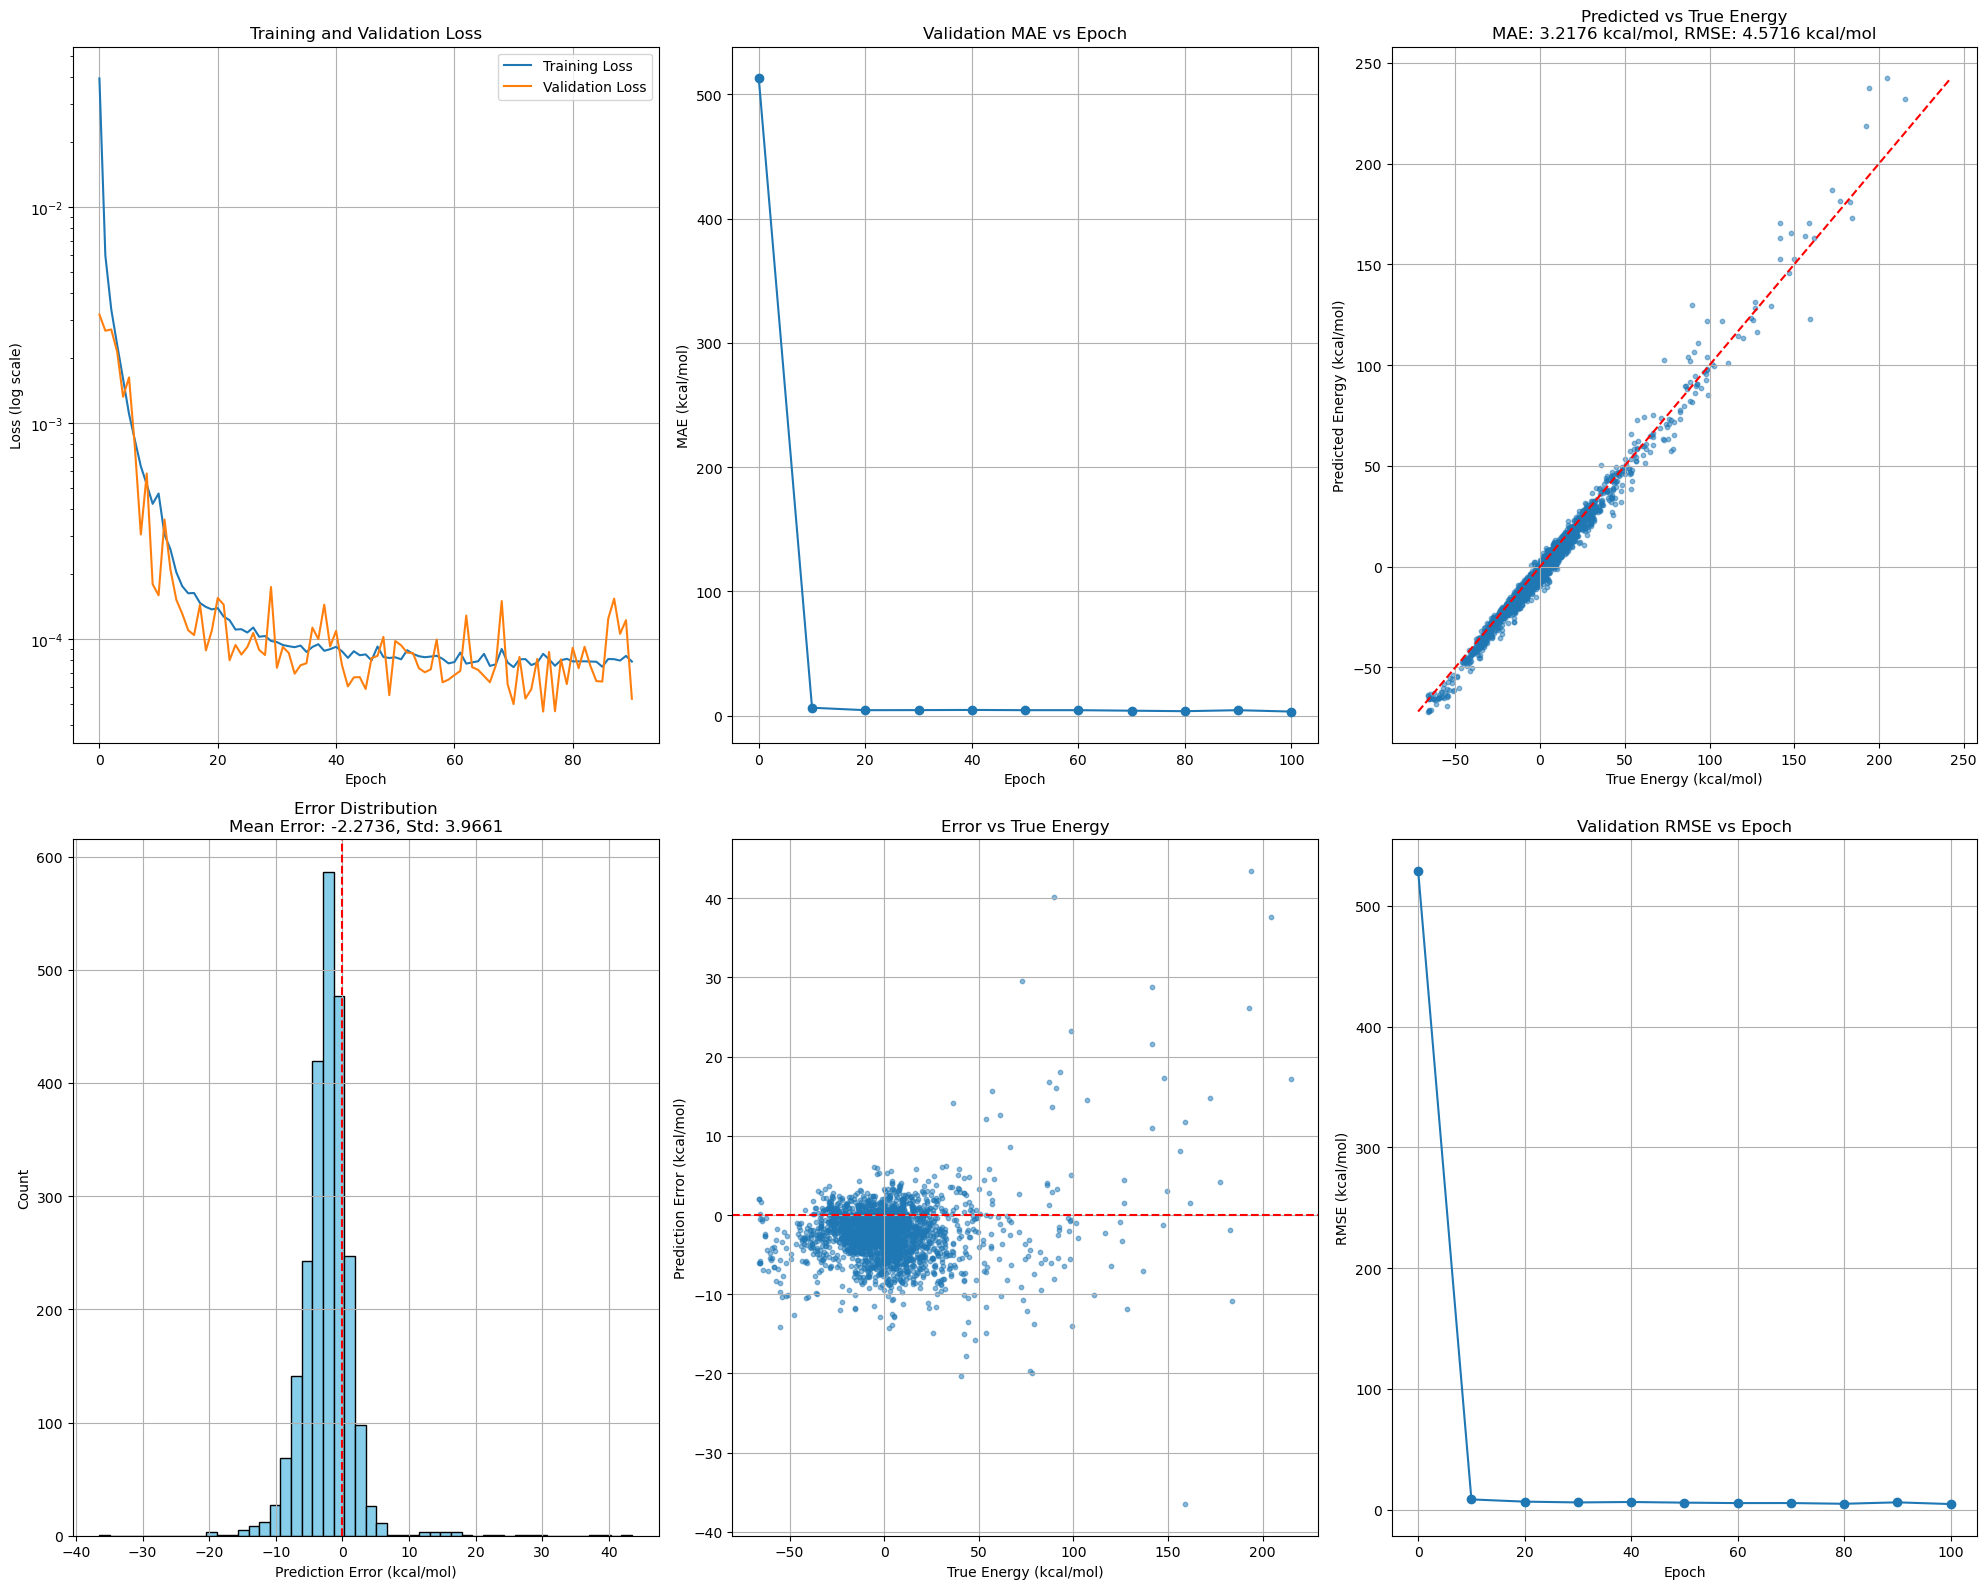

/var/folders/b2/v2rwcjx95bzcfvtp4smbyphr0000gn/T/ipykernel_47876/1530795540.py:251: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


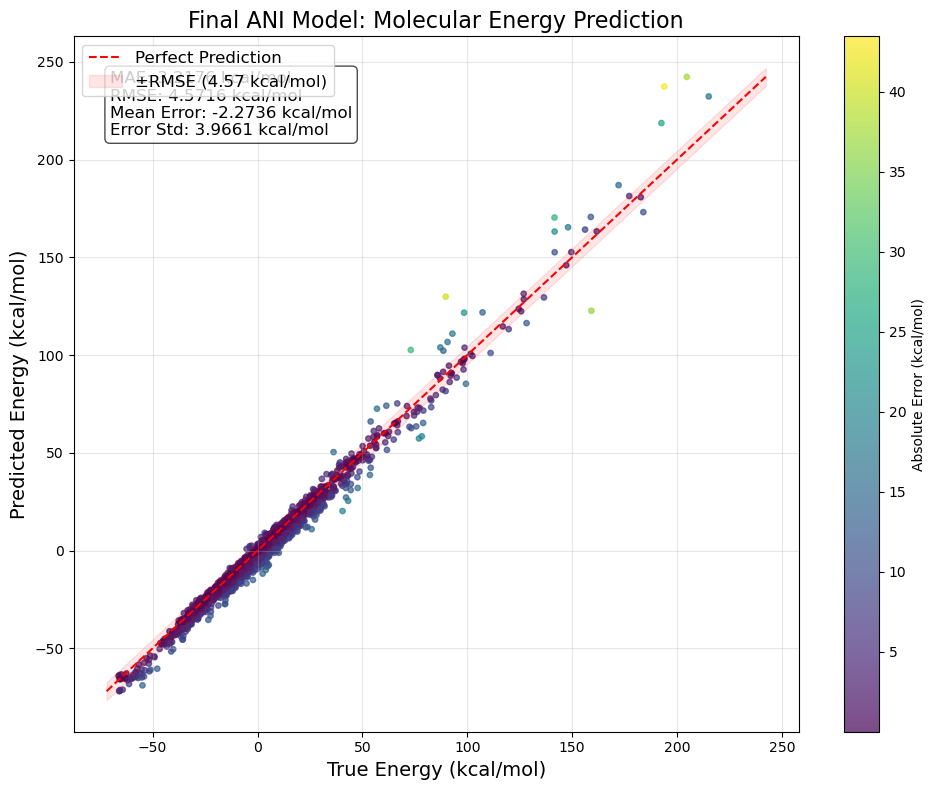


===== FINAL MODEL SUMMARY =====
Architecture: 384 -> 128 -> 64 -> 64 -> 1
Dropout rate: 0.1
L2 regularization: 1e-05
Learning rate: 0.0005 (halved for final training)
Batch size: 32
Training time: 551.66 seconds

===== FINAL MODEL PERFORMANCE =====
MAE: 3.2176 kcal/mol
RMSE: 4.5716 kcal/mol
Mean Error: -2.2736 kcal/mol
Error Std: 3.9661 kcal/mol

===== OUTLIER ANALYSIS =====
Outliers (error > 9.1432 kcal/mol): 85 (3.54%)


In [212]:
print("\n===== FINAL RESULTS: TRAINING WITH ALL DATA =====")

print("Preparing complete dataset...")
all_data = list(islice(train_data, 20000)) + list(islice(val_data, 2000)) + list(islice(test_data, 2000))
all_data_size = len(all_data)
holdout_size = int(all_data_size * 0.1)
training_size = all_data_size - holdout_size

np.random.seed(42)  
np.random.shuffle(all_data)
final_train_data = all_data[:training_size]
final_holdout_data = all_data[training_size:]

final_train_dataset = torchani.data.TransformableIterable(final_train_data)
final_holdout_dataset = torchani.data.TransformableIterable(final_holdout_data)

print("Creating final model with best hyperparameters...")
class FinalAtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, best_hidden_dim),
            nn.BatchNorm1d(best_hidden_dim),
            nn.ReLU(),
            nn.Dropout(best_dropout),
            nn.Linear(best_hidden_dim, best_hidden_dim // 2),
            nn.BatchNorm1d(best_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(best_dropout),
            nn.Linear(best_hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H_ultimate = FinalAtomicNet()
net_C_ultimate = FinalAtomicNet()
net_N_ultimate = FinalAtomicNet()
net_O_ultimate = FinalAtomicNet()
ani_net_ultimate = torchani.ANIModel([net_H_ultimate, net_C_ultimate, net_N_ultimate, net_O_ultimate])
ultimate_model = nn.Sequential(
    aev_computer,
    ani_net_ultimate
).to(device)

FINAL_EPOCHS = 100
final_learning_rate = best_learning_rate * 0.5  

final_trainer = ANITrainer(
    model=ultimate_model,
    batch_size=best_batch_size,
    learning_rate=final_learning_rate,
    epoch=FINAL_EPOCHS,
    l2=best_l2
)

def calculate_metrics(model, data, batch_size=256):
    """Calculate MAE and RMSE metrics on the provided data"""
    data_loader = data.collate(batch_size).cache()
    true_energies_all = []
    pred_energies_all = []
    
    model.eval()
    with torch.no_grad():
        for batch_data in data_loader:
            species = batch_data['species'].to(device)
            coordinates = batch_data['coordinates'].to(device)
            true_energies = batch_data['energies'].to(device).float()
            _, pred_energies = model((species, coordinates))
            
            true_energies_all.append(true_energies.cpu().numpy())
            pred_energies_all.append(pred_energies.cpu().numpy())
    
    true_energies_all = np.concatenate(true_energies_all).flatten()
    pred_energies_all = np.concatenate(pred_energies_all).flatten()
    
    true_energies_kcal = true_energies_all * hartree2kcalmol
    pred_energies_kcal = pred_energies_all * hartree2kcalmol
    
    mae = np.mean(np.abs(true_energies_kcal - pred_energies_kcal))
    rmse = np.sqrt(np.mean((true_energies_kcal - pred_energies_kcal)**2))
    
    return {
        'mae': mae,
        'rmse': rmse,
        'true_values': true_energies_kcal,
        'pred_values': pred_energies_kcal
    }

def training_with_evaluation(model, trainer, train_data, val_data, epochs=100, eval_every=10):
    """Train the model while periodically evaluating on validation data"""
    train_loss_history = []
    val_loss_history = []
    mae_history = []
    rmse_history = []
    
    initial_mae = calculate_metrics(model, val_data, batch_size=trainer.batch_size)['mae']
    initial_rmse = calculate_metrics(model, val_data, batch_size=trainer.batch_size)['rmse']
    mae_history.append(initial_mae)
    rmse_history.append(initial_rmse)
    
    best_val_loss = float('inf')
    best_model_state = None
    patience = 15
    patience_counter = 0
    
    for epoch_start in range(0, epochs, eval_every):
        epoch_end = min(epoch_start + eval_every, epochs)
        epochs_this_segment = epoch_end - epoch_start
        
        if epochs_this_segment <= 0:
            break
            
        print(f"\nTraining epochs {epoch_start+1}-{epoch_end}...")
        
        segment_trainer = ANITrainer(
            model=model,
            batch_size=trainer.batch_size,
            learning_rate=trainer.optimizer.param_groups[0]['lr'],
            epoch=epochs_this_segment,
            l2=trainer.optimizer.param_groups[0]['weight_decay']
        )
        
        train_loss, val_loss = segment_trainer.train(train_data, val_data, draw_curve=False)
        
        train_loss_history.extend(train_loss)
        val_loss_history.extend(val_loss)
        
        metrics = calculate_metrics(model, val_data, batch_size=trainer.batch_size)
        mae_history.append(metrics['mae'])
        rmse_history.append(metrics['rmse'])
        
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"New best model at epoch {epoch_end} (val_loss: {best_val_loss:.6f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch_end}")
                break
        
        print(f"Epochs {epoch_start+1}-{epoch_end} - "
              f"Train Loss: {train_loss[-1]:.6f}, Val Loss: {val_loss[-1]:.6f}, "
              f"MAE: {metrics['mae']:.4f} kcal/mol, RMSE: {metrics['rmse']:.4f} kcal/mol")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model from training")
    
    return {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'mae': mae_history,
        'rmse': rmse_history
    }

print(f"Training final model for up to {FINAL_EPOCHS} epochs...")
start_time = time.time()
training_results = training_with_evaluation(
    ultimate_model, 
    final_trainer, 
    final_train_dataset, 
    final_holdout_dataset, 
    epochs=FINAL_EPOCHS, 
    eval_every=10
)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

print("Evaluating final model on holdout set...")
final_metrics = calculate_metrics(ultimate_model, final_holdout_dataset, batch_size=best_batch_size)

torch.save({
    'model_state_dict': ultimate_model.state_dict(),
    'hyperparameters': {
        'hidden_dim': best_hidden_dim,
        'dropout': best_dropout,
        'learning_rate': final_learning_rate,
        'l2': best_l2,
        'batch_size': best_batch_size
    },
    'metrics': {
        'mae': final_metrics['mae'],
        'rmse': final_metrics['rmse']
    }
}, 'ani_ultimate_model.pt')

print("Final model saved to 'ani_ultimate_model.pt'")

plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 1)
plt.semilogy(training_results['train_loss'], label='Training Loss')
plt.semilogy(training_results['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(range(0, len(training_results['mae'])*10, 10), training_results['mae'], 'o-', label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (kcal/mol)')
plt.title('Validation MAE vs Epoch')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.scatter(final_metrics['true_values'], final_metrics['pred_values'], alpha=0.5, s=10)
min_val = min(min(final_metrics['true_values']), min(final_metrics['pred_values']))
max_val = max(max(final_metrics['true_values']), max(final_metrics['pred_values']))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('True Energy (kcal/mol)')
plt.ylabel('Predicted Energy (kcal/mol)')
plt.title(f'Predicted vs True Energy\nMAE: {final_metrics["mae"]:.4f} kcal/mol, RMSE: {final_metrics["rmse"]:.4f} kcal/mol')
plt.grid(True)

errors = final_metrics['pred_values'] - final_metrics['true_values']
plt.subplot(2, 3, 4)
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error (kcal/mol)')
plt.ylabel('Count')
plt.title(f'Error Distribution\nMean Error: {np.mean(errors):.4f}, Std: {np.std(errors):.4f}')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.scatter(final_metrics['true_values'], errors, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Energy (kcal/mol)')
plt.ylabel('Prediction Error (kcal/mol)')
plt.title('Error vs True Energy')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(range(0, len(training_results['rmse'])*10, 10), training_results['rmse'], 'o-', label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.title('Validation RMSE vs Epoch')
plt.grid(True)

plt.tight_layout()
plt.savefig('ani_ultimate_results.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 8))
cm = plt.cm.get_cmap('viridis')
sc = plt.scatter(final_metrics['true_values'], final_metrics['pred_values'], 
                c=np.abs(errors), cmap=cm, alpha=0.7, s=15)
plt.colorbar(sc, label='Absolute Error (kcal/mol)')

plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

x = np.linspace(min_val, max_val, 100)
plt.fill_between(x, x - final_metrics['rmse'], x + final_metrics['rmse'], 
                 color='red', alpha=0.1, label=f'±RMSE ({final_metrics["rmse"]:.2f} kcal/mol)')

plt.xlabel('True Energy (kcal/mol)', fontsize=14)
plt.ylabel('Predicted Energy (kcal/mol)', fontsize=14)
plt.title('Final ANI Model: Molecular Energy Prediction', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

textstr = '\n'.join((
    f'MAE: {final_metrics["mae"]:.4f} kcal/mol',
    f'RMSE: {final_metrics["rmse"]:.4f} kcal/mol',
    f'Mean Error: {np.mean(errors):.4f} kcal/mol',
    f'Error Std: {np.std(errors):.4f} kcal/mol'
))
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('ani_final_prediction.png', dpi=300)
plt.show()

print("\n===== FINAL MODEL SUMMARY =====")
print(f"Architecture: 384 -> {best_hidden_dim} -> {best_hidden_dim//2} -> 64 -> 1")
print(f"Dropout rate: {best_dropout}")
print(f"L2 regularization: {best_l2}")
print(f"Learning rate: {final_learning_rate} (halved for final training)")
print(f"Batch size: {best_batch_size}")
print(f"Training time: {training_time:.2f} seconds")
print("\n===== FINAL MODEL PERFORMANCE =====")
print(f"MAE: {final_metrics['mae']:.4f} kcal/mol")
print(f"RMSE: {final_metrics['rmse']:.4f} kcal/mol")
print(f"Mean Error: {np.mean(errors):.4f} kcal/mol")
print(f"Error Std: {np.std(errors):.4f} kcal/mol")
print("====================================")

error_threshold = 2 * final_metrics['rmse'] 
outliers = np.where(np.abs(errors) > error_threshold)[0]
outlier_percentage = len(outliers) / len(errors) * 100

print(f"\n===== OUTLIER ANALYSIS =====")
print(f"Outliers (error > {error_threshold:.4f} kcal/mol): {len(outliers)} ({outlier_percentage:.2f}%)")
print("============================")